In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from metrics import MCC

In [2]:
# DATA PATHS

TRAIN_FOLDER_PATH = './data/train/'
VAL_FOLDER_PATH = './data/validation/'
TEST_FOLDER_PATH = './data/test/'

In [3]:
# Hyper parameters

learning_rate = 0.001
batch_size = 20
num_epochs = 60
classes = 2
loss = "binary_crossentropy"

In [4]:
# Data generator

data_gen = ImageDataGenerator(
    rescale = 1 / 255.0,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip = True,
    fill_mode = "nearest"
)

def get_train_generator(img_height, img_width):
    train_generator = data_gen.flow_from_directory(
        TRAIN_FOLDER_PATH,
        target_size = (img_height, img_width),
        color_mode = 'rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True
    )
    
    return train_generator

def get_validation_generator(img_height, img_width):
    validation_generator = data_gen.flow_from_directory(
        VAL_FOLDER_PATH,
        target_size = (img_height, img_width),
        color_mode = 'rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True
    )
    
    return validation_generator

def get_test_generator(img_height, img_width):
    test_generator = data_gen.flow_from_directory(
        TEST_FOLDER_PATH,
        target_size = (img_height, img_width),
        color_mode='rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False
    )
    
    return test_generator

In [5]:
# Callbacks
def get_callbacks():
    mc = ModelCheckpoint('best_custom.h5', monitor='val_MCC', mode='max', verbose=1, save_best_only=True)
    
    return [mc]


In [6]:
# Compile the model

def compile_model(model):
    opt = SGD(lr = learning_rate)
    
    model.compile(loss = loss, optimizer = opt, metrics=["accuracy", MCC])
    
    return model

In [7]:
# Fit the model

def fit_model(model, train_generator, validation_generator):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.n // train_generator.batch_size,
        epochs = num_epochs,
        validation_data = validation_generator,
        validation_steps = validation_generator.n // validation_generator.batch_size,
        use_multiprocessing = False,
        callbacks = get_callbacks())
    
    return history, model


In [8]:
# Save model
def save_model(model, model_name):
    model.save(model_name + '.h5')

In [9]:
# Evaluate the model

def evaluate_model(model, validation_generator):
    return model.evaluate_generator(validation_generator, steps = validation_generator.n // validation_generator.batch_size)


In [10]:
# Predictions

def get_predictions(model, test_generator):
    test_generator.reset()
    
    predIdx = model.predict_generator(test_generator, steps = (test_generator.n // test_generator.batch_size) + 1)
    
    predIdx = np.argmax(predIdx, axis=1)
    
    return predIdx

In [11]:
# Plot accuracy and loss

def plot_metrics(history):
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')

    # summarize history for loss
    plt.subplot(2,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    
    # Plot MCC values
    plt.subplot(2,2,3)
    plt.plot(history.history['MCC'])
    plt.plot(history.history['val_MCC'])
    plt.title('model MCC')
    plt.ylabel('MCC')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

In [12]:
# Show evaluation metrics

def show_eval_metrics(model, metrics):
    for idx, m in enumerate(model.metrics_names):
        print("{}: {:.4f}".format(m, metrics[idx]))


In [13]:
# Show test metrics

def show_test_metrics(predictions, test_generator):
    print(classification_report(test_generator.classes, predictions, target_names=test_generator.class_indices.keys()))

    cm = confusion_matrix(test_generator.classes, predictions)
    total = sum(sum(cm))
    acc = (cm[0,0] + cm[1,1]) / total
    sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
    specificity = cm[1,1] / (cm[1,0] + cm[1,1])

    print("acc: {:.4f}".format(acc))
    print("sensitivity: {:.4f}".format(sensitivity))
    print("specificity: {:.4f}".format(specificity))
    

In [14]:
# Xception model

from tensorflow.keras.applications.xception import Xception

img_width = 299
img_height = 299
img_depth = 3

xception_model = Xception(weights='imagenet', include_top=False, input_shape = (img_height, img_width, img_depth))

model = Sequential()
model.add(xception_model)

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(Dense(2))
model.add(Activation("softmax"))

xception_model.trainable = False

# Hyperparameters

learning_rate = 2e-5
num_epochs = 40


In [15]:
# Compile

model = compile_model(model)

In [16]:
# Create the generators

train_generator = get_train_generator(img_height, img_width)
validation_generator = get_validation_generator(img_height, img_width)
test_generator = get_test_generator(img_height, img_width)

Found 227 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Found 47 images belonging to 2 classes.


In [17]:
# Train

history, model = fit_model(model, train_generator, validation_generator)

Epoch 1/40


W0728 16:23:30.563101 140394303915840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


10/11 [==========================>...] - ETA: 3s - loss: 1.0869 - accuracy: 0.4706 - MCC: -0.0457
Epoch 00001: val_MCC improved from -inf to 0.16667, saving model to best_custom.h5
11/11 [==============================] - 50s 5s/step - loss: 1.0510 - accuracy: 0.4928 - MCC: -0.0052 - val_loss: 0.6801 - val_accuracy: 0.5833 - val_MCC: 0.1667
Epoch 2/40
10/11 [==========================>...] - ETA: 3s - loss: 0.8165 - accuracy: 0.6845 - MCC: 0.3357
Epoch 00002: val_MCC improved from 0.16667 to 0.20000, saving model to best_custom.h5
11/11 [==============================] - 46s 4s/step - loss: 0.7825 - accuracy: 0.6860 - MCC: 0.3416 - val_loss: 0.6457 - val_accuracy: 0.6000 - val_MCC: 0.2000
Epoch 3/40
10/11 [==========================>...] - ETA: 2s - loss: 0.5722 - accuracy: 0.7487 - MCC: 0.5114
Epoch 00003: val_MCC did not improve from 0.20000
11/11 [==============================] - 40s 4s/step - loss: 0.5745 - accuracy: 0.7391 - MCC: 0.4922 - val_loss: 0.6685 - val_accuracy: 0.5833 -

Epoch 26/40
10/11 [==========================>...] - ETA: 3s - loss: 0.1225 - accuracy: 0.9572 - MCC: 0.9200
Epoch 00026: val_MCC did not improve from 0.93333
11/11 [==============================] - 46s 4s/step - loss: 0.1292 - accuracy: 0.9565 - MCC: 0.9182 - val_loss: 0.1533 - val_accuracy: 0.9667 - val_MCC: 0.9333
Epoch 27/40
10/11 [==========================>...] - ETA: 2s - loss: 0.2507 - accuracy: 0.9037 - MCC: 0.8014
Epoch 00027: val_MCC did not improve from 0.93333
11/11 [==============================] - 40s 4s/step - loss: 0.2368 - accuracy: 0.9130 - MCC: 0.8195 - val_loss: 0.1369 - val_accuracy: 0.9333 - val_MCC: 0.8667
Epoch 28/40
10/11 [==========================>...] - ETA: 2s - loss: 0.2018 - accuracy: 0.9037 - MCC: 0.8200
Epoch 00028: val_MCC did not improve from 0.93333
11/11 [==============================] - 38s 3s/step - loss: 0.2136 - accuracy: 0.9034 - MCC: 0.8182 - val_loss: 0.1208 - val_accuracy: 0.9500 - val_MCC: 0.9000
Epoch 29/40
10/11 [=====================

In [18]:
# Save model
save_model(model, 'custom')

In [19]:
# Evaluate

metrics = evaluate_model(model, validation_generator)
show_eval_metrics(model, metrics)

loss: 0.1886
accuracy: 0.9500
MCC: 0.9000


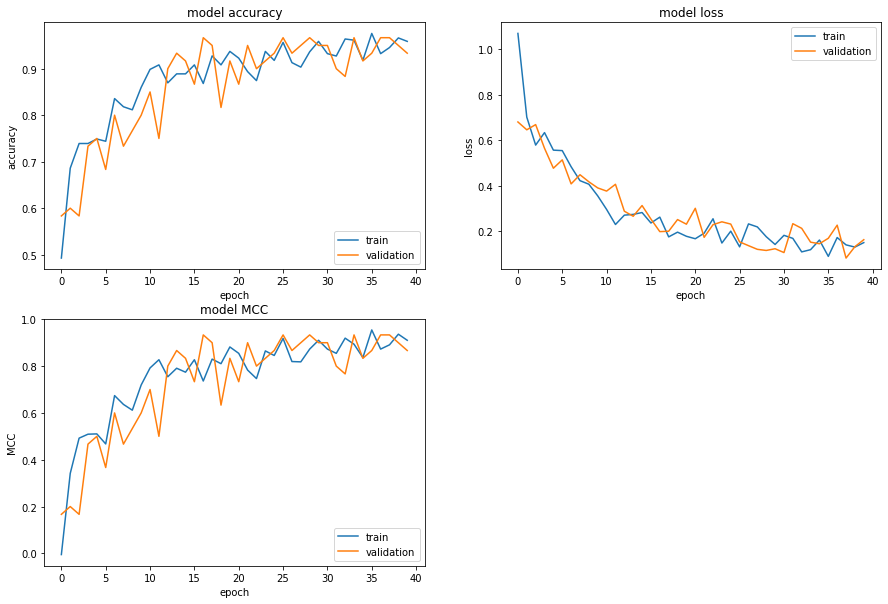

In [20]:
# Plot metrics from history

plot_metrics(history)

In [21]:
# Predictions

predictions = get_predictions(model, test_generator)

In [22]:
# Show final metrics

show_test_metrics(predictions, test_generator)

              precision    recall  f1-score   support

      Blacky       0.91      1.00      0.95        20
       Niche       1.00      0.93      0.96        27

    accuracy                           0.96        47
   macro avg       0.95      0.96      0.96        47
weighted avg       0.96      0.96      0.96        47

acc: 0.9574
sensitivity: 1.0000
specificity: 0.9259
